In [87]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

import geopandas as gpd
import shapely.geometry
import rasterio
import json
import geopandas as gpd
import geopandas_osm.osm
from descartes import PolygonPatch


# load a large-scale image

In [134]:
src = rasterio.open('/home/ubuntu/data/TX_pre/0323323.tif')

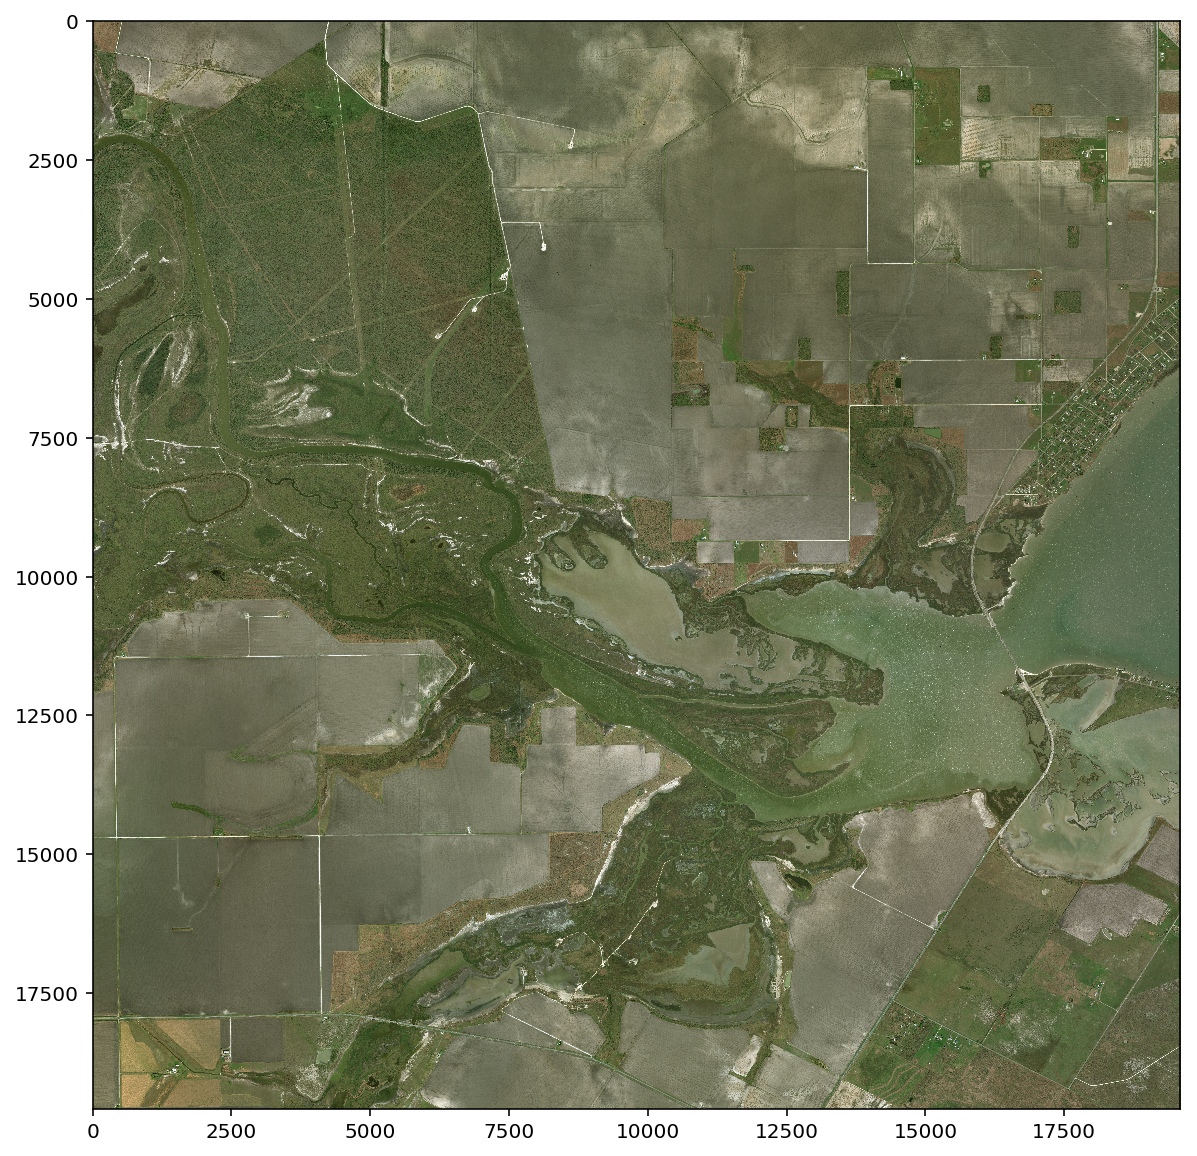

In [135]:
# Load the RGB bands and transpose the image shape
#img = src.read([5, 3, 2]).transpose([1,2,0])
img = src.read([1, 2, 3]).transpose([1,2,0])
# Plot it
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img)

## break the image into more manageable pieces

In [136]:
import os, gdal

in_path = '/home/ubuntu/data/TX_pre/'
input_filename = '0323323.tif'

out_path = '/home/ubuntu/data/TX_pre/output_folder/'
output_filename = 'tile_'

tile_size_x = 512
tile_size_y = 512

ds = gdal.Open(in_path + input_filename)
band = ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

for i in range(0, xsize, tile_size_x):
    for j in range(0, ysize, tile_size_y):
        com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(in_path) + str(input_filename) + " " + str(out_path) + str(output_filename) + str(i) + "_" + str(j) + ".tif"
        os.system(com_string)

In [137]:
files = !ls /home/ubuntu/data/TX_pre/output_folder/
len(files)

1521

In [138]:
file = files[699] 
print(file)
src = rasterio.open('/home/ubuntu/data/TX_pre/output_folder/'+file)

#is the file empty (all zeros)?
src.read().sum() == 0

tile_17408_8704.tif


False

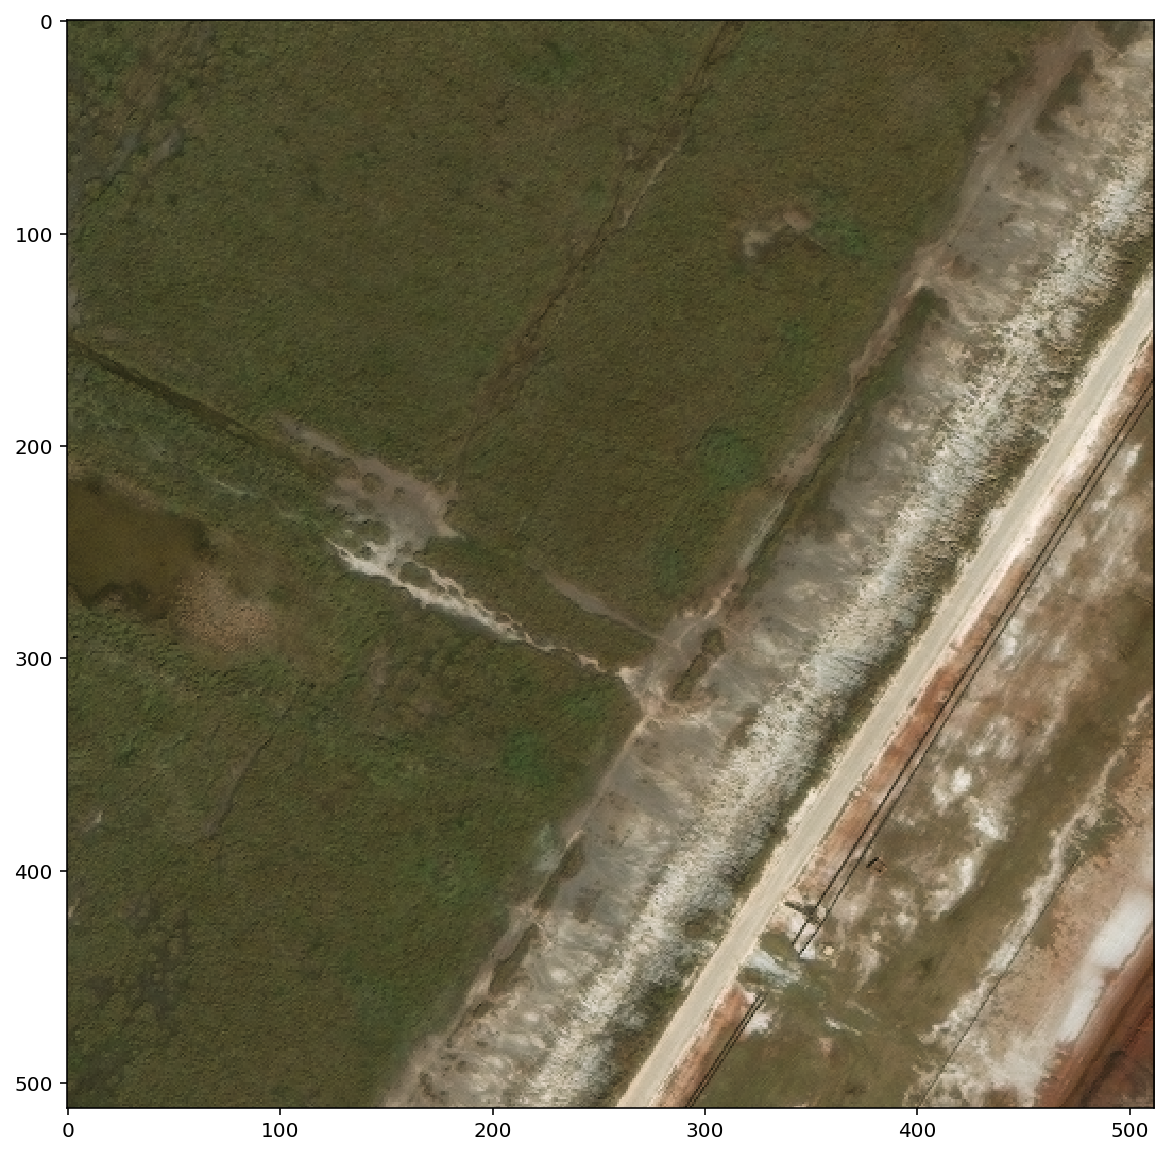

In [37]:
# Load the RGB bands and transpose the image shape
#img = src.read([5, 3, 2]).transpose([1,2,0])
img = src.read([1, 2, 3]).transpose([1,2,0])
# Plot it
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img)

In [38]:
img.sum()

69220302

In [39]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled

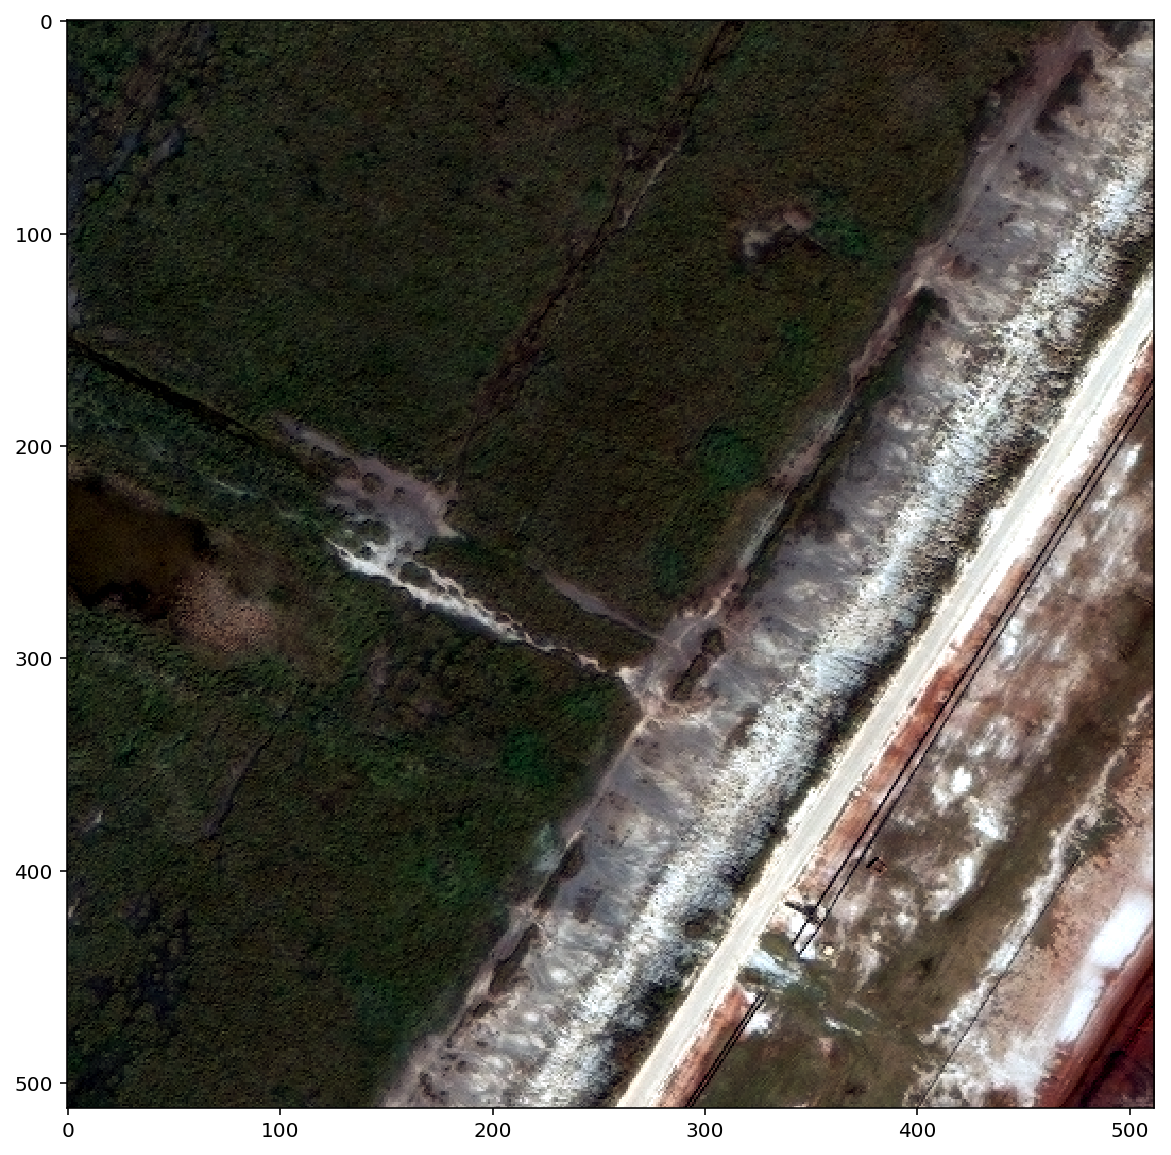

In [40]:
# Plot the rescaled image
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(scale_bands(img))

In [41]:
print(src.width, src.height, src.count)

(512, 512, 3)


In [42]:
print(src.crs)
print(src.transform)

CRS({'init': u'epsg:4326'})
[-97.216796875, 4.487879136029412e-06, 0.0, 27.998046875, 0.0, -4.487879136029412e-06]


In [43]:
src.bounds

BoundingBox(left=-97.216796875, bottom=27.99574908088235, right=-97.21449908088235, top=27.998046875)

In [44]:
tiff_images = !ls /home/ubuntu/data/TX_pre/output_folder/
tiff_images[:]

['tile_0_0.tif',
 'tile_0_10240.tif',
 'tile_0_1024.tif',
 'tile_0_10752.tif',
 'tile_0_11264.tif',
 'tile_0_11776.tif',
 'tile_0_12288.tif',
 'tile_0_12800.tif',
 'tile_0_13312.tif',
 'tile_0_13824.tif',
 'tile_0_14336.tif',
 'tile_0_14848.tif',
 'tile_0_15360.tif',
 'tile_0_1536.tif',
 'tile_0_15872.tif',
 'tile_0_16384.tif',
 'tile_0_16896.tif',
 'tile_0_17408.tif',
 'tile_0_17920.tif',
 'tile_0_18432.tif',
 'tile_0_18944.tif',
 'tile_0_19456.tif',
 'tile_0_2048.tif',
 'tile_0_2560.tif',
 'tile_0_3072.tif',
 'tile_0_3584.tif',
 'tile_0_4096.tif',
 'tile_0_4608.tif',
 'tile_0_5120.tif',
 'tile_0_512.tif',
 'tile_0_5632.tif',
 'tile_0_6144.tif',
 'tile_0_6656.tif',
 'tile_0_7168.tif',
 'tile_0_7680.tif',
 'tile_0_8192.tif',
 'tile_0_8704.tif',
 'tile_0_9216.tif',
 'tile_0_9728.tif',
 'tile_10240_0.tif',
 'tile_10240_10240.tif',
 'tile_10240_1024.tif',
 'tile_10240_10752.tif',
 'tile_10240_11264.tif',
 'tile_10240_11776.tif',
 'tile_10240_12288.tif',
 'tile_10240_12800.tif',
 'tile_102

In [45]:
res = []

for image_file_name in tiff_images:
    print(image_file_name)
    with rasterio.open('/home/ubuntu/data/TX_pre/output_folder/'+image_file_name) as src:
        
        # Convert the image bounding box into a shapely polygon
        bbox = shapely.geometry.box(*src.bounds)
        
    res.append((image_file_name, bbox))

# Convert the results into a GeoDataFrame
image_summary = gpd.GeoDataFrame(res, columns=['image_name', 'geometry'], crs={'init': 'epsg:4326'})

#note:   EPSG 3857 a possible alternative to 4326, try if things don't line up well

tile_0_0.tif
tile_0_10240.tif
tile_0_1024.tif
tile_0_10752.tif
tile_0_11264.tif
tile_0_11776.tif
tile_0_12288.tif
tile_0_12800.tif
tile_0_13312.tif
tile_0_13824.tif
tile_0_14336.tif
tile_0_14848.tif
tile_0_15360.tif
tile_0_1536.tif
tile_0_15872.tif
tile_0_16384.tif
tile_0_16896.tif
tile_0_17408.tif
tile_0_17920.tif
tile_0_18432.tif
tile_0_18944.tif
tile_0_19456.tif
tile_0_2048.tif
tile_0_2560.tif
tile_0_3072.tif
tile_0_3584.tif
tile_0_4096.tif
tile_0_4608.tif
tile_0_5120.tif
tile_0_512.tif
tile_0_5632.tif
tile_0_6144.tif
tile_0_6656.tif
tile_0_7168.tif
tile_0_7680.tif
tile_0_8192.tif
tile_0_8704.tif
tile_0_9216.tif
tile_0_9728.tif
tile_10240_0.tif
tile_10240_10240.tif
tile_10240_1024.tif
tile_10240_10752.tif
tile_10240_11264.tif
tile_10240_11776.tif
tile_10240_12288.tif
tile_10240_12800.tif
tile_10240_13312.tif
tile_10240_13824.tif
tile_10240_14336.tif
tile_10240_14848.tif
tile_10240_15360.tif
tile_10240_1536.tif
tile_10240_15872.tif
tile_10240_16384.tif
tile_10240_16896.tif
tile_10240

tile_15872_4608.tif
tile_15872_5120.tif
tile_15872_512.tif
tile_15872_5632.tif
tile_15872_6144.tif
tile_15872_6656.tif
tile_15872_7168.tif
tile_15872_7680.tif
tile_15872_8192.tif
tile_15872_8704.tif
tile_15872_9216.tif
tile_15872_9728.tif
tile_16384_0.tif
tile_16384_10240.tif
tile_16384_1024.tif
tile_16384_10752.tif
tile_16384_11264.tif
tile_16384_11776.tif
tile_16384_12288.tif
tile_16384_12800.tif
tile_16384_13312.tif
tile_16384_13824.tif
tile_16384_14336.tif
tile_16384_14848.tif
tile_16384_15360.tif
tile_16384_1536.tif
tile_16384_15872.tif
tile_16384_16384.tif
tile_16384_16896.tif
tile_16384_17408.tif
tile_16384_17920.tif
tile_16384_18432.tif
tile_16384_18944.tif
tile_16384_19456.tif
tile_16384_2048.tif
tile_16384_2560.tif
tile_16384_3072.tif
tile_16384_3584.tif
tile_16384_4096.tif
tile_16384_4608.tif
tile_16384_5120.tif
tile_16384_512.tif
tile_16384_5632.tif
tile_16384_6144.tif
tile_16384_6656.tif
tile_16384_7168.tif
tile_16384_7680.tif
tile_16384_8192.tif
tile_16384_8704.tif
tile_1

tile_5120_13824.tif
tile_5120_14336.tif
tile_5120_14848.tif
tile_5120_15360.tif
tile_5120_1536.tif
tile_5120_15872.tif
tile_5120_16384.tif
tile_5120_16896.tif
tile_5120_17408.tif
tile_5120_17920.tif
tile_5120_18432.tif
tile_5120_18944.tif
tile_5120_19456.tif
tile_5120_2048.tif
tile_5120_2560.tif
tile_5120_3072.tif
tile_5120_3584.tif
tile_5120_4096.tif
tile_5120_4608.tif
tile_5120_5120.tif
tile_5120_512.tif
tile_5120_5632.tif
tile_5120_6144.tif
tile_5120_6656.tif
tile_5120_7168.tif
tile_5120_7680.tif
tile_5120_8192.tif
tile_5120_8704.tif
tile_5120_9216.tif
tile_5120_9728.tif
tile_512_0.tif
tile_512_10240.tif
tile_512_1024.tif
tile_512_10752.tif
tile_512_11264.tif
tile_512_11776.tif
tile_512_12288.tif
tile_512_12800.tif
tile_512_13312.tif
tile_512_13824.tif
tile_512_14336.tif
tile_512_14848.tif
tile_512_15360.tif
tile_512_1536.tif
tile_512_15872.tif
tile_512_16384.tif
tile_512_16896.tif
tile_512_17408.tif
tile_512_17920.tif
tile_512_18432.tif
tile_512_18944.tif
tile_512_19456.tif
tile_51

In [46]:
image_summary.head()

image_name                                           geometry
0      tile_0_0.tif  POLYGON ((-97.29262408088235 28.03481158088235...
1  tile_0_10240.tif  POLYGON ((-97.29262408088235 27.98885569852941...
2   tile_0_1024.tif  POLYGON ((-97.29262408088235 28.03021599264706...
3  tile_0_10752.tif  POLYGON ((-97.29262408088235 27.98655790441176...
4  tile_0_11264.tif  POLYGON ((-97.29262408088235 27.98426011029412...

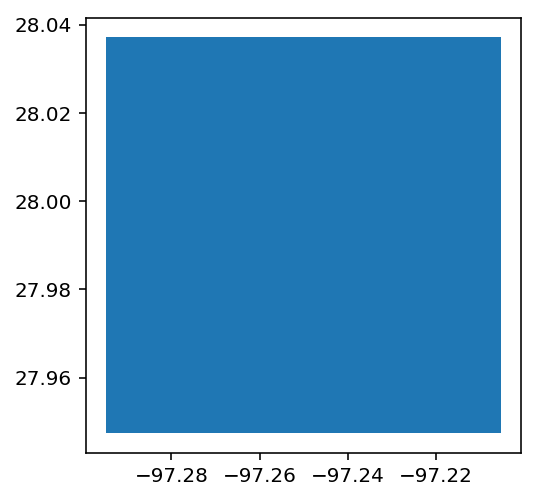

In [47]:
image_summary.plot()

In [48]:
!pwd

/home/ubuntu/Notebooks


In [49]:
!mkdir vectors

mkdir: cannot create directory ‘vectors’: File exists


In [50]:
output_file_name = 'vectors/TX_image_summary_test.geojson'

# Make sure the file doesnt exist (the program will crash if it does)
if os.path.exists(output_file_name):
    os.remove(output_file_name)

# Save the file as a geojson
image_summary.to_file(output_file_name, driver='GeoJSON')

### start ground truth collection process

In [51]:
meta_df = gpd.read_file(output_file_name)
poly = shapely.geometry.box(*meta_df.unary_union.bounds)

In [52]:
meta_df.head(3)

image_name                                           geometry
0      tile_0_0.tif  POLYGON ((-97.29262408088235 28.03481158088235...
1  tile_0_10240.tif  POLYGON ((-97.29262408088235 27.98885569852941...
2   tile_0_1024.tif  POLYGON ((-97.29262408088235 28.03021599264706...

In [53]:
meta_df.unary_union.bounds

(-97.294921875, 27.947495404411764, -97.20530790441175, 28.037109375)

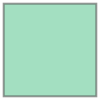

In [54]:
poly

#### Query Open Street Maps (OSM) for landuse, waterways, and nature tags

In [63]:
!rm 'vectors/landuse_TX_test.geojson'
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='landuse')
landuse = osm_df[~osm_df.landuse.isnull()]
print(landuse.landuse.unique())
print(landuse.shape)
landuse.to_file('vectors/landuse_TX_test.geojson', 'GeoJSON')

rm: cannot remove 'vectors/landuse_TX_test.geojson': No such file or directory


KeyError: 'lon'

In [64]:
!rm 'vectors/waterways.geojson'
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='waterway')
waterways = osm_df[~osm_df.waterway.isnull()]
print(waterways.waterway.unique())
print(waterways.shape)
waterways.to_file('vectors/waterways.geojson', 'GeoJSON')

['riverbank' 'stream' 'drain']
(6, 8)


In [65]:
!rm 'vectors/nature.geojson'
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='natural')
nature = osm_df[~osm_df.natural.isnull()]
print(nature.natural.unique())
print(nature.shape)
nature.to_file('vectors/nature.geojson', 'GeoJSON')

['water']
(1, 9)


In [66]:
osm_waterways = gpd.read_file('vectors/waterways.geojson')
osm_waterways.head()

gnis:fcode         id   waterway   tunnel  \
0      46006  174281847  riverbank     None   
1       None  519156625     stream  culvert   
2       None  519156626     stream     None   
3       None  519156627     stream     None   
4       None  519736065      drain     None   

                                      description                 name  \
0                                            None                 None   
1                                            None                 None   
2                                            None                 None   
3                                            None                 None   
4  Taft Drainage Ditch; direction of flow unknown  Taft Drainage Ditch   

    wikidata                                           geometry  
0       None  LINESTRING (-97.2749634 28.016532, -97.2742171...  
1       None  LINESTRING (-97.2093852 28.0188663, -97.209552...  
2       None  LINESTRING (-97.2093852 28.0188663, -97.209296...  
3       None  LINESTRING (-97.20955290000001 28.0186179, -97...  
4  Q31541776  LINESTRING (-97.3691376 27.9646067, -97.361141...

In [67]:
osm_nature = gpd.read_file('vectors/nature.geojson')
osm_nature.head()

gnis:fcode gnis:ftype         id          man_made                    name  \
0      43604  Reservoir  138490311  wastewater_plant  Tailing Ponds Number 2   

  natural nhd:com_id  nhd:reach_code  \
0   water  128281741  12100405004634   

                                            geometry  
0  LINESTRING (-97.2126264 28.0000003, -97.211932...

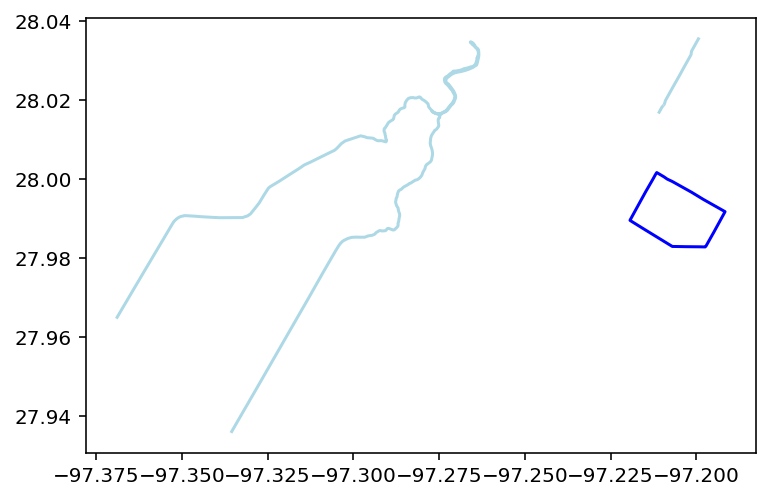

In [113]:
fig, ax = plt.subplots()
osm_waterways[osm_waterways != 'drain'].plot(color='lightblue',ax=ax)
osm_nature[osm_nature.natural == 'water'].plot(color='blue',ax=ax)

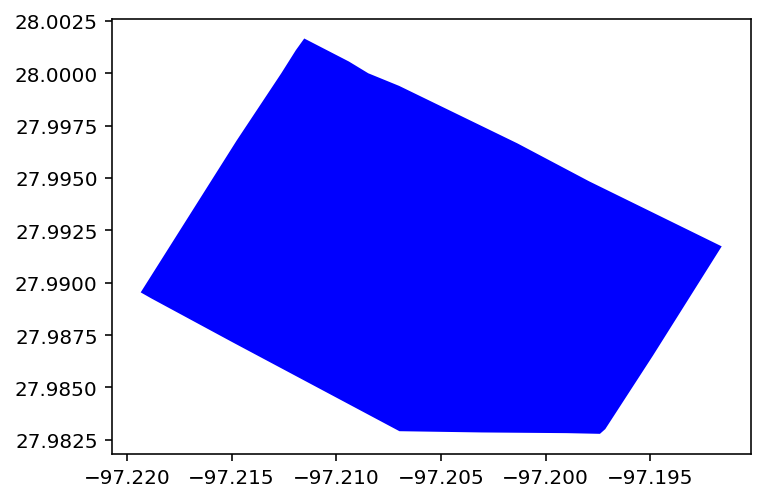

In [116]:
osm_nature.set_geometry(osm_nature.geometry.apply(shapely.geometry.Polygon), inplace=True)
osm_nature[osm_nature.natural == 'water'].plot(color='blue')

In [123]:
osm_waterways.set_geometry(osm_waterways.geometry.apply(shapely.geometry.Polygon), inplace=True)
osm_waterways[osm_waterways != 'drain'].plot(color='blue',figsize=(10,14))

TypeError: 'float' object is not iterable

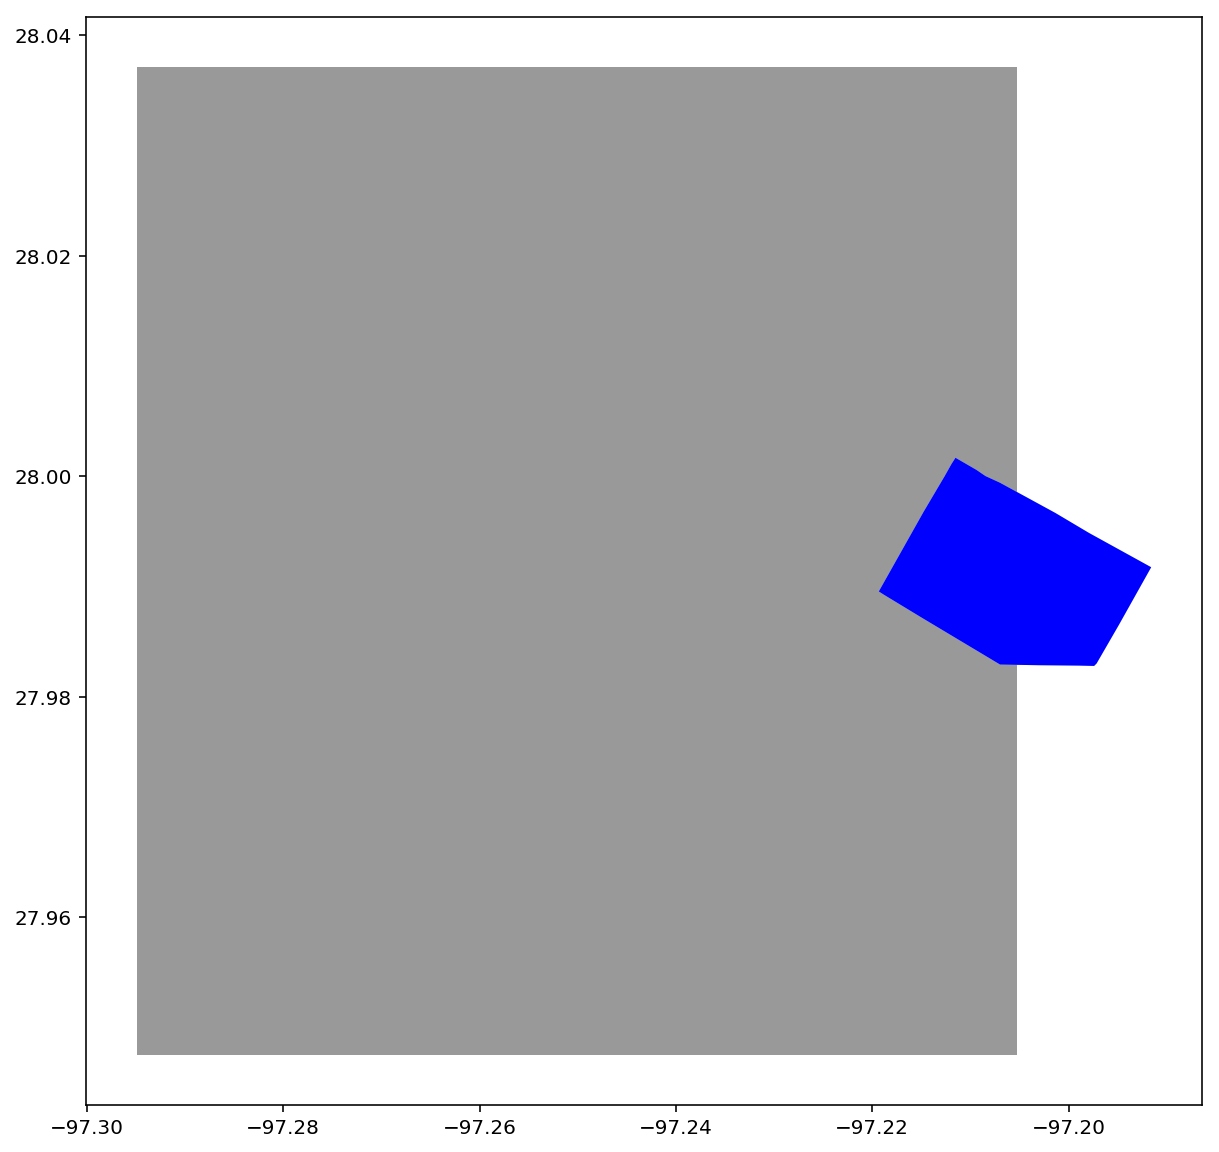

In [124]:
image_summary = gpd.read_file('vectors/TX_image_summary_test.geojson')
fig, ax = plt.subplots(figsize = (10,10))
image_summary.plot(color='grey', alpha=0.8, linewidth=1.2, ax=ax)
osm_waterways[osm_waterways != 'drain'].plot(color='lightblue',ax=ax)
osm_nature[osm_nature.natural == 'water'].plot(color='blue',ax=ax)


In [125]:
#put the water sets together

part1 = osm_waterways[osm_waterways != 'drain'].unary_union
part2 = osm_nature[osm_nature.natural == 'water'].unary_union
all_water = osm_nature[osm_nature.natural == 'water'].unary_union    #part1.union(part2)

images_containing_water = image_summary[image_summary.intersects(all_water)]
images_containing_water.head()

AttributeError: 'float' object has no attribute '_geom'

In [126]:
file_name = images_containing_water.image_name.values[1]

with rasterio.open("/home/ubuntu/data/TX_pre/output_folder/"+file_name) as src:
        img = scale_bands(src.read([1, 2, 3]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        img_crs = src.crs

In [127]:
import pyproj
def reproject_shapely(proj_init, proj_targ, poly):
    project = functools.partial(
        pyproj.transform,
        pyproj.Proj(proj_init),
        pyproj.Proj(proj_targ)
    )
    return shapely.ops.transform(project, poly)

# If the image is not projected in epsg:4326, we will need to change the polygon to match the image
if not img_crs == {'init': 'epsg:4326'}:
    all_water = reproject_shapely({'init': 'epsg:4326'}, img_crs, all_water)

In [128]:
# Get the intersection between the forest and the image bounds
image_water_area = all_water.intersection(img_bounds)

# Transform it into pixel coordinates
image_water_area_pxcoords = shapely.affinity.affine_transform(image_water_area, img_transform)

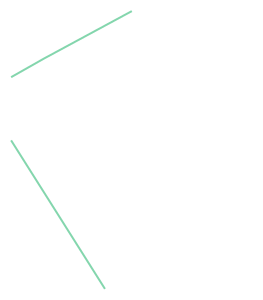

In [129]:
image_water_area_pxcoords

ValueError: A polygon or multi-polygon representation is required

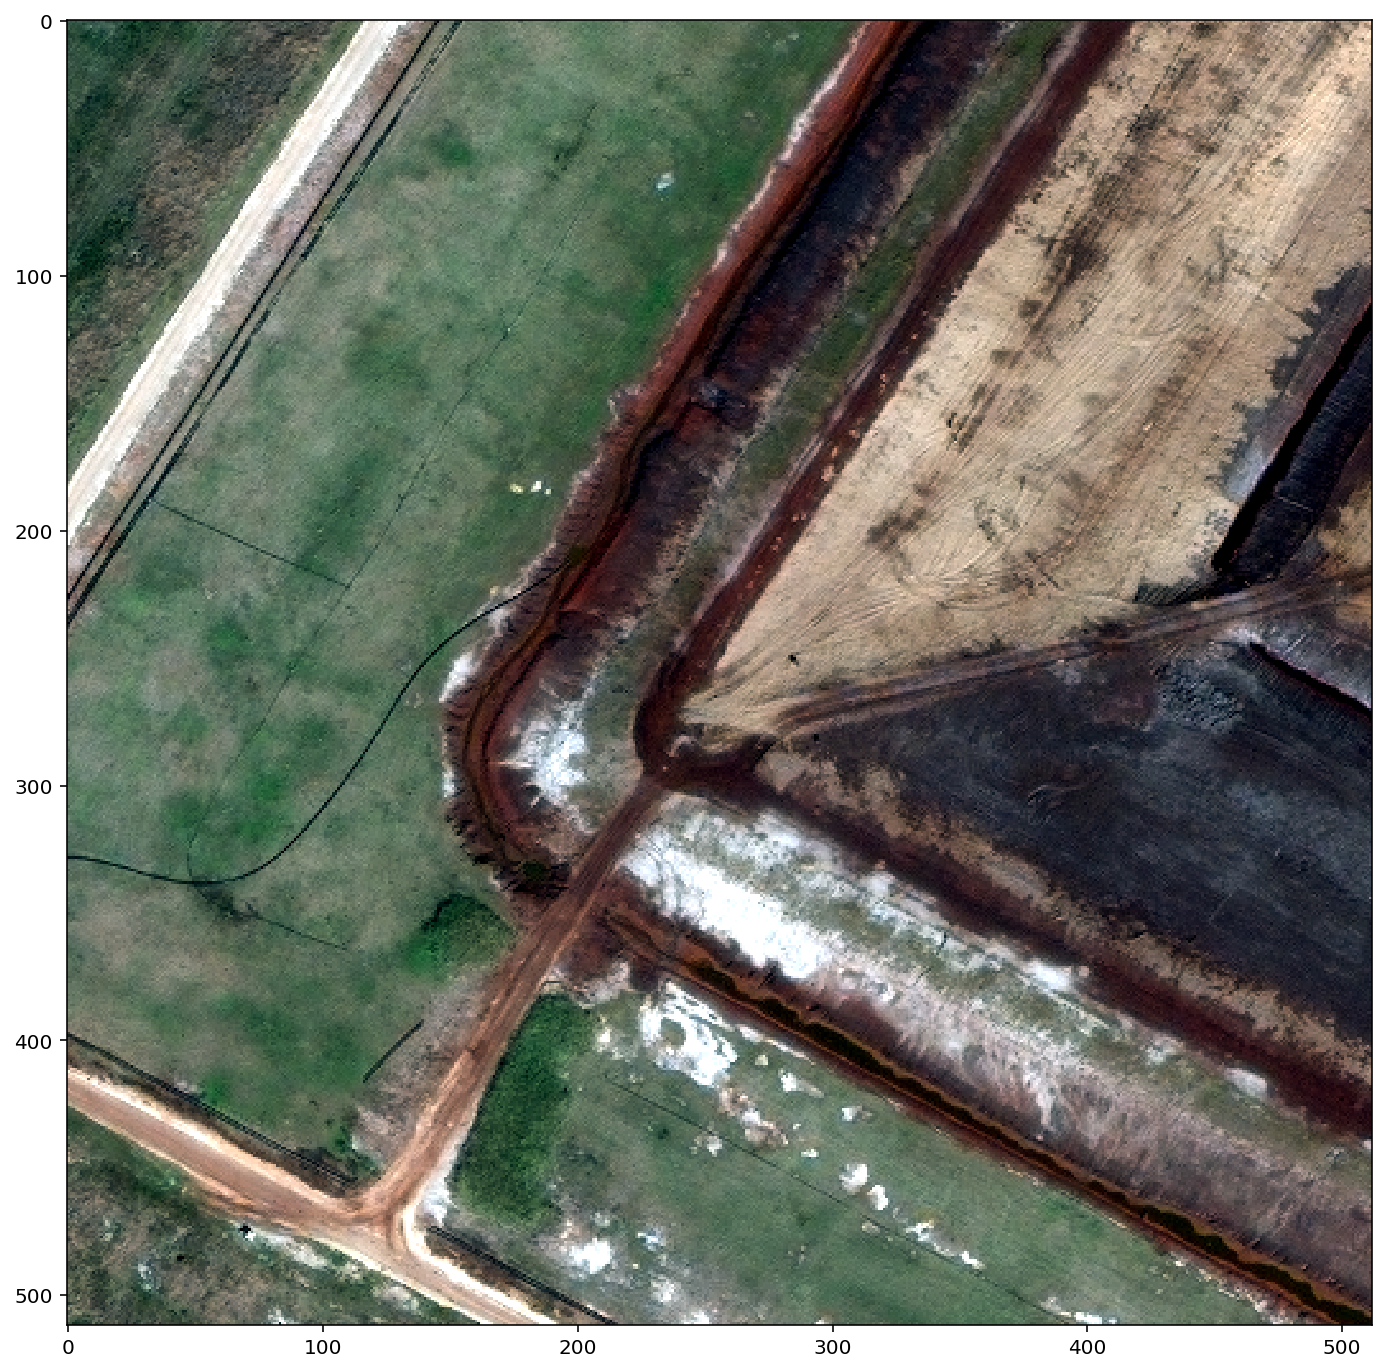

In [130]:
fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_water_area_pxcoords, fc='g', alpha=0.4, hatch='//'))

In [131]:
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

# Prepare a collection of PolygonPatches so we can plot it.
patches = [PolygonPatch(poly,fc='b', ec='b', alpha=0.5)
           for poly in all_water]

# Create a figure
fig, ax = plt.subplots()

# Show all of the forest areas
ax.add_collection(PatchCollection(patches, match_original=True))

# Show the image box
ax.add_patch(PolygonPatch(img_bounds))

# Rescale the axes
ax.autoscale_view()

TypeError: 'LineString' object is not iterable

In [132]:
# Calculate the proportion of each image taken up by water
proportion_water = images_containing_water.intersection(all_water).area / images_containing_water.area

# Find the images with between 30% and 80% forest
has_some_forest = np.logical_and(0.2 < proportion_water, proportion_water < 0.9)
images_containing_some_water = images_containing_water[has_some_forest]

# Pick the first image on the list
file_name = images_containing_some_water.image_name.values[2]

# Load the image
with rasterio.open("/home/ubuntu/data/AOI_3_Paris_Train/MUL-PanSharpen/"+file_name) as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        img_crs = src.crs
        
# Get the intersection between the forest and the image bounds
image_water_area = all_water.intersection(img_bounds)

# Transform it into pixel coordinates
image_water_area_pxcoords = shapely.affinity.affine_transform(image_water_area, img_transform)

fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_water_area_pxcoords, fc='b', alpha=0.4, hatch='//'))

IndexError: index 2 is out of bounds for axis 0 with size 0

Encountered unrecognized geometry type MultiLineString. Ignoring.


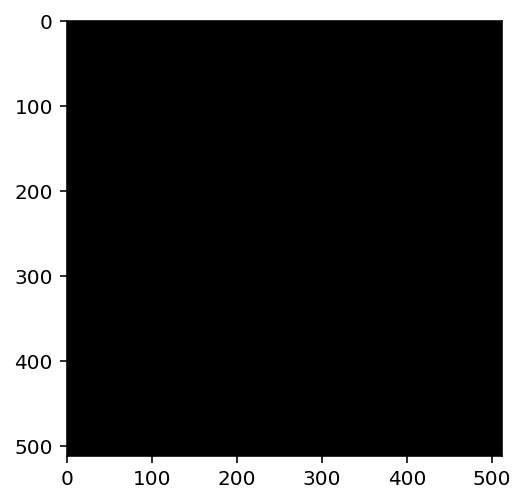

In [133]:
import cv2

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

# Convert the forest polygon into a mask
water_mask = make_mask(img.shape, image_water_area_pxcoords)

# Plot it
plt.imshow(water_mask, cmap=plt.cm.gray)